# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [15]:
file_list = ["Dijet_bb_pt20_50_dw.root"]
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

# do for each df:

for file in file_list:
# Read the ROOT file
    tree = uproot.open(file + ":" + path_to_tree)
    df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

    # Clean column names and remove unwanted columns
    df.columns = [col.rstrip('_') if col.endswith('_') else col for col in df.columns]
    rename_columns(df)
    columns_to_remove = [col for col in df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
    df.drop(columns=columns_to_remove, inplace=True)
    for col in df.columns:
        if "SVtag" in col:
            df[col] = df[col].apply(extract_float) 
    print(df.info(verbose=True))
    print(df.head())
    # Check for and remove duplicate events
    #df = df.drop_duplicates(subset=['Jet0_PT'])
    print(df.columns)

full_bb_df = df

In [16]:
file_list = ["Dijet_cc_pt20_50_dw.root"]
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

# do for each df:

for file in file_list:
# Read the ROOT file
    tree = uproot.open(file + ":" + path_to_tree)
    df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

    # Clean column names and remove unwanted columns
    df.columns = [col.rstrip('_') if col.endswith('_') else col for col in df.columns]
    rename_columns(df)
    columns_to_remove = [col for col in df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
    df.drop(columns=columns_to_remove, inplace=True)
    for col in df.columns:
        if "SVtag" in col:
            df[col] = df[col].apply(extract_float) 
    print(df.info(verbose=True))
    print(df.head())
    # Check for and remove duplicate events
    #df = df.drop_duplicates(subset=['Jet0_PT'])
    print(df.columns)

full_cc_df = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 418 columns):
 #    Column                               Dtype  
---   ------                               -----  
 0    Jet0_ENDVERTEX_X                     float64
 1    Jet0_ENDVERTEX_Y                     float64
 2    Jet0_ENDVERTEX_Z                     float64
 3    Jet0_ENDVERTEX_XERR                  float64
 4    Jet0_ENDVERTEX_YERR                  float64
 5    Jet0_ENDVERTEX_ZERR                  float64
 6    Jet0_ENDVERTEX_CHI2                  float64
 7    Jet0_ENDVERTEX_NDOF                  int32  
 8    Jet0_OWNPV_X                         float64
 9    Jet0_OWNPV_Y                         float64
 10   Jet0_OWNPV_Z                         float64
 11   Jet0_OWNPV_XERR                      float64
 12   Jet0_OWNPV_YERR                      float64
 13   Jet0_OWNPV_ZERR                      float64
 14   Jet0_OWNPV_CHI2                      float64
 15   Jet0_OWNPV_NDOF

In [17]:
file_list = ["Dijet_qq_pt20_50_dw.root"]
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

# do for each df:

for file in file_list:
# Read the ROOT file
    tree = uproot.open(file + ":" + path_to_tree)
    df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

    # Clean column names and remove unwanted columns
    df.columns = [col.rstrip('_') if col.endswith('_') else col for col in df.columns]
    rename_columns(df)
    columns_to_remove = [col for col in df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
    df.drop(columns=columns_to_remove, inplace=True)
    for col in df.columns:
        if "SVtag" in col:
            df[col] = df[col].apply(extract_float) 
    print(df.info(verbose=True))
    print(df.head())
    # Check for and remove duplicate events
    #df = df.drop_duplicates(subset=['Jet0_PT'])
    print(df.columns)

full_qq_df = df

In [11]:
full_bb_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,nITClusters,nTTClusters,nOTClusters,nSPDHits,nMuonCoordsS0,nMuonCoordsS1,nMuonCoordsS2,nMuonCoordsS3,nMuonCoordsS4,nMuonTracks
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,671,875,5547,328,349,154,50,6,6,10
1,0.7844,-0.1852,-61.7426,0.0074,0.0073,0.0379,68.600578,167,0.783929,-0.185155,...,926,894,5557,403,409,109,14,4,7,5
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,370,545,3854,158,179,56,33,7,6,1
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,105,556,2695,118,129,114,33,4,9,3
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.799059,-0.161079,...,1169,1391,8587,586,668,243,19,14,14,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.865574,-0.171921,...,1090,1300,6663,492,562,154,7,1,7,0
599996,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.864690,-0.170872,...,1090,1300,6663,492,562,154,7,1,7,0
599997,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.864690,-0.170872,...,1090,1300,6663,492,562,154,7,1,7,0
599998,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.864690,-0.170872,...,1090,1300,6663,492,562,154,7,1,7,0


In [18]:
full_qq_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,nITClusters,nTTClusters,nOTClusters,nSPDHits,nMuonCoordsS0,nMuonCoordsS1,nMuonCoordsS2,nMuonCoordsS3,nMuonCoordsS4,nMuonTracks
0,0.8358,-0.2203,-20.3618,0.0082,0.0082,0.0532,41.952824,117,0.835810,-0.219127,...,562,1132,5064,322,453,301,65,-1,4,1
1,0.8358,-0.2203,-20.3618,0.0082,0.0082,0.0532,41.952824,117,0.835810,-0.219127,...,562,1132,5064,322,453,301,65,-1,4,1
2,0.8358,-0.2203,-20.3618,0.0082,0.0082,0.0532,41.952824,117,0.835579,-0.221971,...,562,1132,5064,322,453,301,65,-1,4,1
3,0.7903,-0.1978,5.1348,0.0093,0.0093,0.0548,29.411797,79,0.790325,-0.197676,...,274,710,2824,162,195,36,76,6,4,3
4,0.7903,-0.1978,5.1348,0.0093,0.0093,0.0548,29.411797,79,0.789595,-0.197481,...,274,710,2824,162,195,36,76,6,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,1016,991,6975,409,450,160,29,13,12,4
599996,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859215,-0.177662,...,1016,991,6975,409,450,160,29,13,12,4
599997,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859068,-0.178895,...,1016,991,6975,409,450,160,29,13,12,4
599998,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859205,-0.178072,...,1016,991,6975,409,450,160,29,13,12,4


In [19]:
full_cc_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,nITClusters,nTTClusters,nOTClusters,nSPDHits,nMuonCoordsS0,nMuonCoordsS1,nMuonCoordsS2,nMuonCoordsS3,nMuonCoordsS4,nMuonTracks
0,0.7971,-0.1303,-1.8904,0.0294,0.0250,0.1305,2.910482,7,0.834700,-0.157000,...,395,1094,6651,277,285,58,11,7,11,6
1,0.9403,-0.0762,-5.5935,0.0438,0.0513,0.4423,6.530856,5,0.876096,-0.193302,...,507,772,5119,347,372,181,19,19,4,6
2,0.9403,-0.0762,-5.5935,0.0438,0.0513,0.4423,6.530856,5,0.876096,-0.193302,...,507,772,5119,347,372,181,19,19,4,6
3,0.9403,-0.0762,-5.5935,0.0438,0.0513,0.4423,6.530856,5,0.876190,-0.193588,...,507,772,5119,347,372,181,19,19,4,6
4,0.8085,-0.1778,3.4408,0.0076,0.0076,0.0489,76.717255,161,0.808109,-0.176474,...,1290,1699,10469,411,430,109,29,6,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.8638,-0.1613,-26.0319,0.0063,0.0063,0.0313,85.648140,207,0.865020,-0.162155,...,986,1687,6193,402,511,101,26,11,7,10
599996,0.7808,-0.1997,-6.4312,0.0124,0.0116,0.0567,19.961155,53,0.780740,-0.200057,...,112,380,2488,101,104,32,4,2,2,0
599997,0.9203,-0.1362,31.2725,0.0345,0.0329,0.4827,3.169039,7,0.792900,-0.220500,...,687,732,4850,297,375,95,20,14,8,8
599998,0.8108,-0.2181,46.8730,0.0069,0.0069,0.0436,47.757725,147,0.810897,-0.215077,...,531,908,4345,208,233,29,7,3,4,1


This reads the signal and background data from the csv, then creates a new dataframe with the complete raw data. After combining the signal and background data, it is separated again and assigned truth values in a new column, "IsB". This indicates whether or not it is a b-jet. The data is also selected to only include the leading jet data. Truth matching is done on both the signal and background data, and cuts are applied to only include high momentum jets with a defined pseudorapidity within the range of the detector. The features are defined, including sv tagging as jet-level features.

In [63]:
# Define signal and background data
sig_df = full_bb_df
bkg_df = full_qq_df

full_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Assign truth labels: 1 for signal (b-jet) and 0 for background (non-b-jet)
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

KeyboardInterrupt: 

In [ ]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
1,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
2,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
3,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,0.7638,-0.2149,27.5546,0.0068,0.0071,0.0337,47.428341,129,0.763140,-0.216845,...,True,True,True,True,True,True,True,True,True,0
660,0.8187,-0.1823,83.7097,0.0095,0.0096,0.0656,26.397013,79,0.816728,-0.179955,...,True,True,True,True,True,True,True,True,True,0
661,0.8049,-0.2041,17.7010,0.0089,0.0095,0.0444,39.309906,95,0.805086,-0.198989,...,True,True,True,True,True,True,True,True,False,0
662,0.8399,-0.2419,10.7219,0.0071,0.0067,0.0375,71.126114,159,0.839823,-0.242719,...,False,False,False,True,False,False,True,False,False,0


In [56]:
sum(combined_df.IsB)

342

In [5]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
1,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
2,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
3,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411535,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.857450,-0.177311,...,True,True,True,True,True,True,True,True,False,0
411536,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0
411537,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0
411538,0.8592,-0.1786,-89.0739,0.0070,0.0069,0.0400,54.918781,141,0.859150,-0.179140,...,True,True,True,True,True,True,True,True,False,0


The csv stores daughter information as a string, so the prepare features function converts them into accessible lists of floats. This function also duplicates jet-level features into lists of floats with lengths equal to the number of nodes in each jet, in order to match the formatting of the daughter-level features, where each float in a list corresponds to a daughter. The data is processed into a new dataframe. Then, the signal and background features are separated again. Training and testing data are created with equal parts of shuffled signal and background data, in a 80:20 ratio of the available leading jet data. The data before processing with signal and background combined includes 600k jets. After the truth matching and cuts are applied, there are 411,540 jets.

In [6]:
# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

# Split data into training, validation, and test sets
sig_df = df[df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

half_train_size = 160000
half_test_size = 40000

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
train_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8375,-0.1526,2.9495,0.0100,0.0099,0.0585,43.323650,93,0.838157,-0.154143,...,True,True,True,True,True,True,True,True,True,1
1,0.8079,-0.1899,27.3367,0.0072,0.0073,0.0428,44.022839,139,0.874574,-0.169007,...,True,True,True,True,True,True,True,True,True,0
2,0.8420,-0.1505,9.8445,0.0078,0.0080,0.0408,55.133335,123,0.863300,-0.194100,...,True,True,True,True,True,True,True,True,False,0
3,0.8387,-0.1486,-9.6972,0.0089,0.0090,0.0498,37.490570,95,0.836304,-0.146917,...,True,True,True,True,True,True,True,True,True,0
4,0.7824,-0.1986,-37.4033,0.0067,0.0067,0.0289,63.519657,159,0.783324,-0.198777,...,True,True,True,True,True,True,True,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,0.9282,-0.1552,-21.4546,0.0198,0.0207,0.1196,4.637649,13,0.868032,-0.196206,...,True,True,True,True,True,True,True,True,True,1
319996,0.8646,-0.1834,6.8233,0.0159,0.0159,0.0984,10.685744,25,0.841300,-0.166100,...,True,True,True,True,True,True,True,True,False,0
319997,0.8284,-0.1329,50.2082,0.0348,0.0238,0.3631,4.496447,13,0.824800,-0.229000,...,True,True,True,True,True,True,True,True,True,1
319998,0.8364,-0.2016,4.7028,0.0066,0.0065,0.0339,66.884567,171,0.837020,-0.202891,...,True,True,True,True,True,True,True,True,True,1


In [11]:
sum(train_df.IsB)

160000

In [14]:
test_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8179,-0.1936,42.6847,0.0103,0.0102,0.0571,29.646257,69,0.818711,-0.187840,...,True,True,True,True,True,True,True,False,True,0
1,0.8515,-0.2363,-109.4345,0.0134,0.0135,0.1646,14.316007,41,0.851973,-0.242751,...,True,True,True,True,True,True,True,True,False,0
2,0.8397,-0.1617,-6.7698,0.0064,0.0064,0.0340,83.287354,187,0.823478,-0.178142,...,False,False,False,True,False,False,True,False,False,0
3,0.7854,-0.1487,6.0242,0.0064,0.0064,0.0356,74.854950,187,0.786000,-0.148372,...,False,False,False,True,False,False,True,False,False,0
4,0.8538,-0.1760,6.4302,0.0085,0.0078,0.0436,66.145798,145,0.854593,-0.175949,...,False,False,False,True,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.8666,-0.1320,-9.7054,0.0120,0.0122,0.0534,18.844786,43,0.866649,-0.128948,...,True,True,True,True,True,True,True,True,False,1
79996,0.8909,-0.1926,11.3419,0.0098,0.0096,0.0551,42.637142,89,0.817903,-0.177044,...,True,True,True,True,True,True,True,True,False,0
79997,0.8016,-0.2055,-51.9654,0.0086,0.0084,0.0410,43.956753,107,0.801856,-0.203331,...,True,True,True,True,True,True,True,False,True,0
79998,0.8394,-0.2039,15.2006,0.0172,0.0174,0.1154,9.564524,27,0.840139,-0.197275,...,True,True,True,True,True,True,True,True,True,1


In [12]:
sum(test_df.IsB)

40000

In [16]:
validation_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8336,-0.1711,-44.5789,0.0097,0.0095,0.0405,34.614410,69,0.831835,-0.169603,...,True,True,True,True,True,True,True,True,True,0
1,0.8563,-0.2063,59.5434,0.0073,0.0073,0.0456,70.645790,153,0.856633,-0.204793,...,True,True,True,True,True,True,True,True,True,1
2,0.8246,-0.1719,-1.4738,0.0284,0.0272,0.1442,5.933709,9,0.857684,-0.211821,...,True,True,True,True,True,True,True,True,True,1
3,0.8467,-0.1036,-19.1631,0.0287,0.0288,0.1691,6.977366,13,0.821667,-0.168392,...,True,True,True,True,True,True,True,True,True,1
4,0.8697,-0.1764,7.6602,0.0071,0.0070,0.0370,56.750942,161,0.869373,-0.176427,...,True,True,True,True,True,True,True,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11535,0.8415,-0.2006,7.0810,0.0163,0.0156,0.1094,16.483074,31,0.840604,-0.203865,...,True,True,True,True,True,True,True,True,False,0
11536,0.8111,-0.1986,-39.5350,0.0329,0.0307,0.1695,3.062654,7,0.870330,-0.174203,...,True,True,True,True,True,True,True,True,False,1
11537,0.8537,-0.1741,-19.4231,0.0073,0.0071,0.0399,73.431023,169,0.854337,-0.174632,...,False,False,False,True,False,False,True,False,False,1
11538,0.8823,-0.2110,11.3031,0.0101,0.0101,0.0934,43.697102,99,0.882470,-0.213882,...,True,True,True,True,True,True,True,True,True,1


In [17]:
sum(validation_df.IsB)

7832

The node features are processed into an array, so the data can be transformed into data object, representing one row or jet in the data. The feature array is used to create a tensor of the node features. The graphs are created with fully connected edges, but without self-connectioned nodes. The adjacency matrix of the graph is of size [number of nodes] x [number of nodes] filled with ones except the diagonal has zeros. The y tensor holds the truth labels, for graph-level classification. The data is then loaded in batches.

In [18]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Hyperparameter Tuning - Random Search

In order to tune hyperparameters, I created a new model to adjust the numer of layers, hidden channels, dropout, learning rate, and weight decay. I kept the same evaluation loops, and a parameters function to randomly extract different parameter values. Over 10 epochs for each of the 20 trials, the performance of the model is evaluated via the validation accuracy, and the best parameters are printed. Ultimately, the best hyperparameter found in this search led to overfitting with negliigible improvement, so I kept the original configurations.

In [389]:
def search_model(num_layers, hidden_channels, dropout_rate, learning_rate, weight_decay):
    class GNN(torch.nn.Module):
        def __init__(self, num_layers, hidden_channels, dropout_rate):
            super(GNN, self).__init__()
            self.convs = nn.ModuleList()
            self.lns = nn.ModuleList()
            self.num_layers = num_layers

            self.convs.append(SAGEConv(len(feature_cols), hidden_channels))
            self.lns.append(LayerNorm(hidden_channels))
            for _ in range(num_layers - 1):
                self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                self.lns.append(LayerNorm(hidden_channels))
            
            self.lin = Linear(hidden_channels, 1)
            self.dropout = Dropout(dropout_rate)

        def forward(self, x, edge_index, batch):
            for i in range(self.num_layers):
                x = self.convs[i](x, edge_index)
                x = self.lns[i](x)
                x = F.relu(x)
                if i < self.num_layers - 1:
                    x = self.dropout(x)

            x = global_add_pool(x, batch)
            x = self.lin(x)
            return x.squeeze(1)

    model = GNN(num_layers, hidden_channels, dropout_rate)
    
    # Define optimizer and criterion
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    def train():
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            clip_grad_norm_(model.parameters(), max_norm=0.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        avg_loss = total_loss / len(train_loader.dataset)
        return avg_loss

    # Testing function
    def test(loader):
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0
        
        with torch.no_grad():
            for data in loader:
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y.float())
                pred = (out > 0).float()
                correct = (pred.squeeze() == data.y.float()).sum().item()
                total_correct += correct
                total_samples += len(data.y)
                total_loss += loss.item() * data.num_graphs

            avg_loss = total_loss / len(loader.dataset)
            acc = total_correct / total_samples
        return avg_loss, acc

    for epoch in range(20):
        train_loss = train()
        test_loss, test_acc = test(test_loader)
        scheduler.step(test_loss)
    
    return test_acc

In [390]:
def parameters():
    num_layers = random.randint(2, 5)
    hidden_channels = random.choice([64, 128, 256])
    dropout_rate = random.choice([0.2, 0.3])
    learning_rate = random.choice([0.001, 0.0001])
    weight_decay = 10 ** random.choice([-4, -3, -2])

    params = {
            'num_layers': num_layers,
            'hidden_channels': hidden_channels,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay
        }
    return params

In [391]:
# Random search
num_trials = 20
best_acc = 0
best_params = None
num_epochs = 10

for trial in range(num_trials):
    params = parameters()
    print(f"Trial {trial + 1}/{num_trials}")
    print(f"Testing with parameters: {params}")
    
    test_acc = search_model(
        num_layers=params['num_layers'],
        hidden_channels=params['hidden_channels'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    
    print(f"Test Accuracy: {test_acc:.4f}")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_params = params

    print(f"Current Best Accuracy: {best_acc:.4f}")
    print("--------------------")

print(f"Best Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")

Trial 1/20
Testing with parameters: {'num_layers': 2, 'hidden_channels': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
Test Accuracy: 0.8006
Current Best Accuracy: 0.8006
--------------------
Trial 2/20
Testing with parameters: {'num_layers': 5, 'hidden_channels': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.01}
Test Accuracy: 0.8060
Current Best Accuracy: 0.8060
--------------------
Trial 3/20
Testing with parameters: {'num_layers': 2, 'hidden_channels': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.001}
Test Accuracy: 0.8040
Current Best Accuracy: 0.8060
--------------------
Trial 4/20
Testing with parameters: {'num_layers': 4, 'hidden_channels': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.01}
Test Accuracy: 0.8047
Current Best Accuracy: 0.8060
--------------------
Trial 5/20
Testing with parameters: {'num_layers': 5, 'hidden_channels': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'we

# Classifier

The model is defined with 64 hidden channels, using SAGEConv (sample and aggregate) for the convolutional layers, which aggregates features from its local neighbors. Each iteration of the convolutional layers access the next layer of surrounding nodes. ReLU activation functions are used between each layer, and dropout layers zero out graph representation tensors with a probability of 30% for regularization. After the message passing process, a global add pooling layer and linear layer work together to map the output to a single logit.

In [6]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()

# Model Evaluation

The model is trained on the graphs using the classifier defined above. During the training loop, the gradients are clipped to prevent exploding gradients and overfitting. Loss is calculated for the training data aand minimized with the AdamW optimizer. In the test function, the loss is calculated for just the validation data, and the accuracy is computed for both. Then, for every epoch, the loss and accuracy values are stored as lists, and the learning rate is decreased when the validation data loss plateaus. The loss and accuracy for the training and validation data are printed, then plotted for all epochs.

In [7]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

'''best_loss = float('inf')
best_model_weights = None
patience = 15'''

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    # Early stopping after 15 epochs if test loss does not improve
    '''if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'morestats2_model.pth')
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            break'''

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
torch.save(model.state_dict(), 'morestats2_model.pth')
#model.load_state_dict(torch.load('fullrun_model.pth'))
final_test_loss, final_test_acc = test(test_loader)
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Acc: {final_test_acc:.4f}')

Epoch: 001, Train Loss: 0.4614, Test Loss: 0.4339, Train Acc: 0.8014, Test Acc: 0.7986
Epoch: 002, Train Loss: 0.4286, Test Loss: 0.4237, Train Acc: 0.8027, Test Acc: 0.8000
Epoch: 003, Train Loss: 0.4231, Test Loss: 0.4183, Train Acc: 0.8041, Test Acc: 0.8016
Epoch: 004, Train Loss: 0.4203, Test Loss: 0.4178, Train Acc: 0.8043, Test Acc: 0.8018
Epoch: 005, Train Loss: 0.4185, Test Loss: 0.4180, Train Acc: 0.8042, Test Acc: 0.8021
Epoch: 006, Train Loss: 0.4168, Test Loss: 0.4168, Train Acc: 0.8051, Test Acc: 0.8027
Epoch: 007, Train Loss: 0.4158, Test Loss: 0.4152, Train Acc: 0.8046, Test Acc: 0.8022
Epoch: 008, Train Loss: 0.4150, Test Loss: 0.4176, Train Acc: 0.8044, Test Acc: 0.8018
Epoch: 009, Train Loss: 0.4143, Test Loss: 0.4136, Train Acc: 0.8050, Test Acc: 0.8026
Epoch: 010, Train Loss: 0.4136, Test Loss: 0.4179, Train Acc: 0.8039, Test Acc: 0.8013
Epoch: 011, Train Loss: 0.4130, Test Loss: 0.4134, Train Acc: 0.8050, Test Acc: 0.8029
Epoch: 012, Train Loss: 0.4122, Test Loss: 

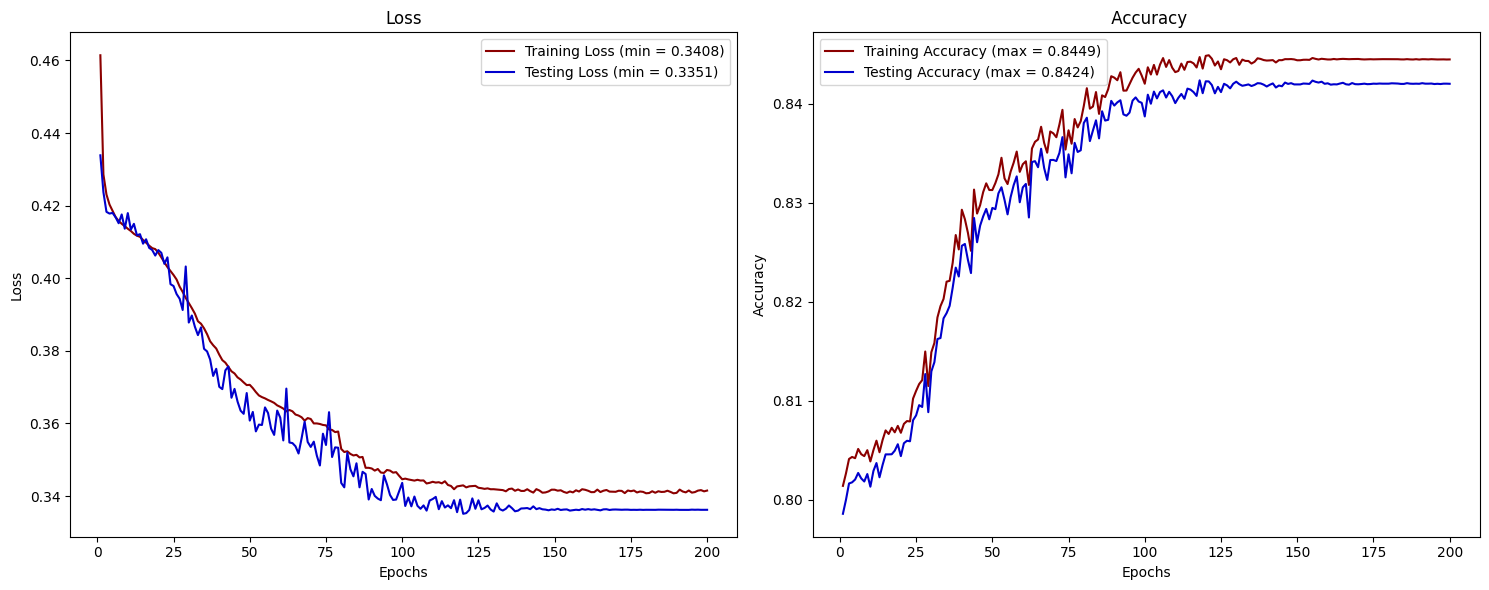

In [79]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

In [95]:
# Load a model to use for evaluation - most recent is morestats_model.pth
#model.load_state_dict(torch.load('morestats_model.pth'))

<All keys matched successfully>

In [9]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [49]:
desired_tpr = 0.8
closest_index = np.argmin(np.abs(tpr - desired_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {desired_tpr}: Pb {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.8: Pb 0.4183: FPR 0.1192


In [50]:
# Get FPRs for TPRs
desired_tpr = [.6, .65, .7, 0.75, 0.8, 0.85]

for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    chosen_threshold = thresholds[closest_index]
    chosen_fpr = fpr[closest_index]
    print(f"{val}: {chosen_fpr:.4f}")

0.6: 0.0067
0.65: 0.0135
0.7: 0.0324
0.75: 0.0688
0.8: 0.1192
0.85: 0.1954


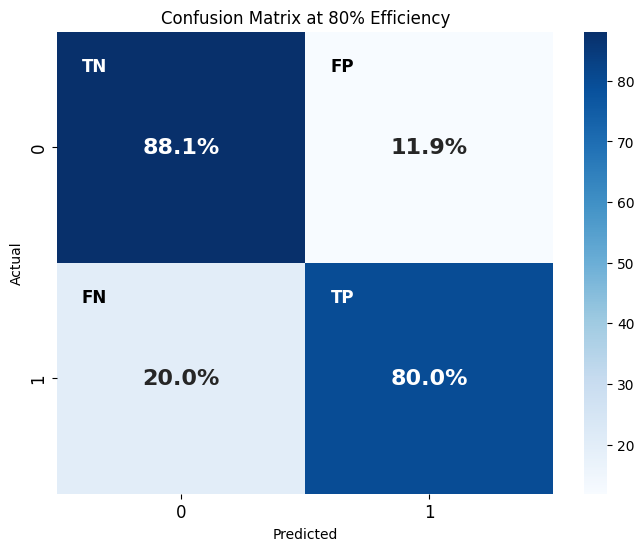

In [80]:
y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix at 80% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

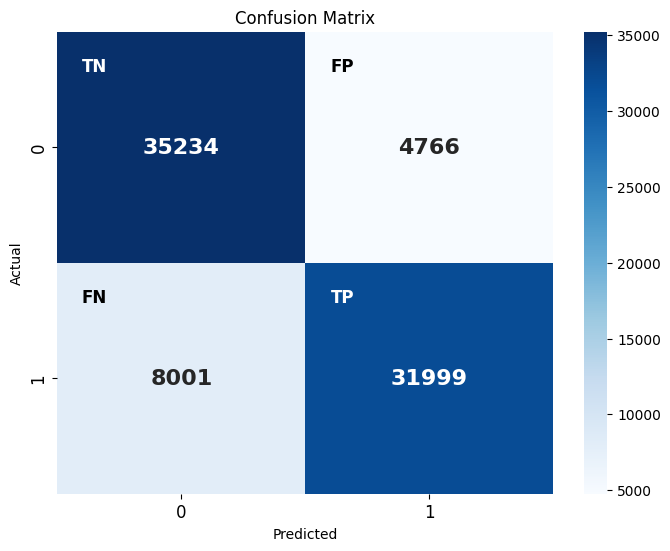

In [52]:
y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

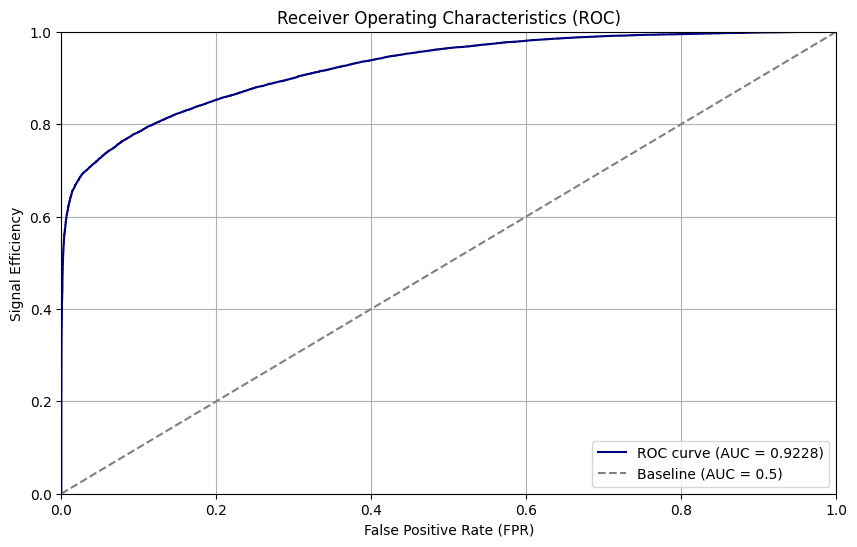

In [81]:
# Plot ROC Curve and show AUC, mark optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

                                Feature  Importance
0                      Jet0_Daughters_E    1.325775
1                     Jet0_Daughters_pT    0.853019
2                     Jet0_Daughters_ID    0.065098
3                     Jet0_Daughters_pX    0.517047
4                     Jet0_Daughters_pY    0.478604
5                     Jet0_Daughters_pZ    0.993635
6                    Jet0_Daughters_Eta    0.008416
7                    Jet0_Daughters_Phi    0.003847
8                      Jet0_Daughters_Q    0.001120
9                     Jet0_Daughters_IP    0.073537
10                Jet0_Daughters_IPCHI2    1.813385
11                 Jet0_Daughters_IPraw    0.025692
12                   Jet0_Daughters_NNe    0.098613
13                   Jet0_Daughters_NNk    0.101542
14                   Jet0_Daughters_NNp    0.334530
15                  Jet0_Daughters_NNpi    0.098294
16                  Jet0_Daughters_NNmu    2.051632
17                  Jet0_Daughters_Chi2    0.273826
18          

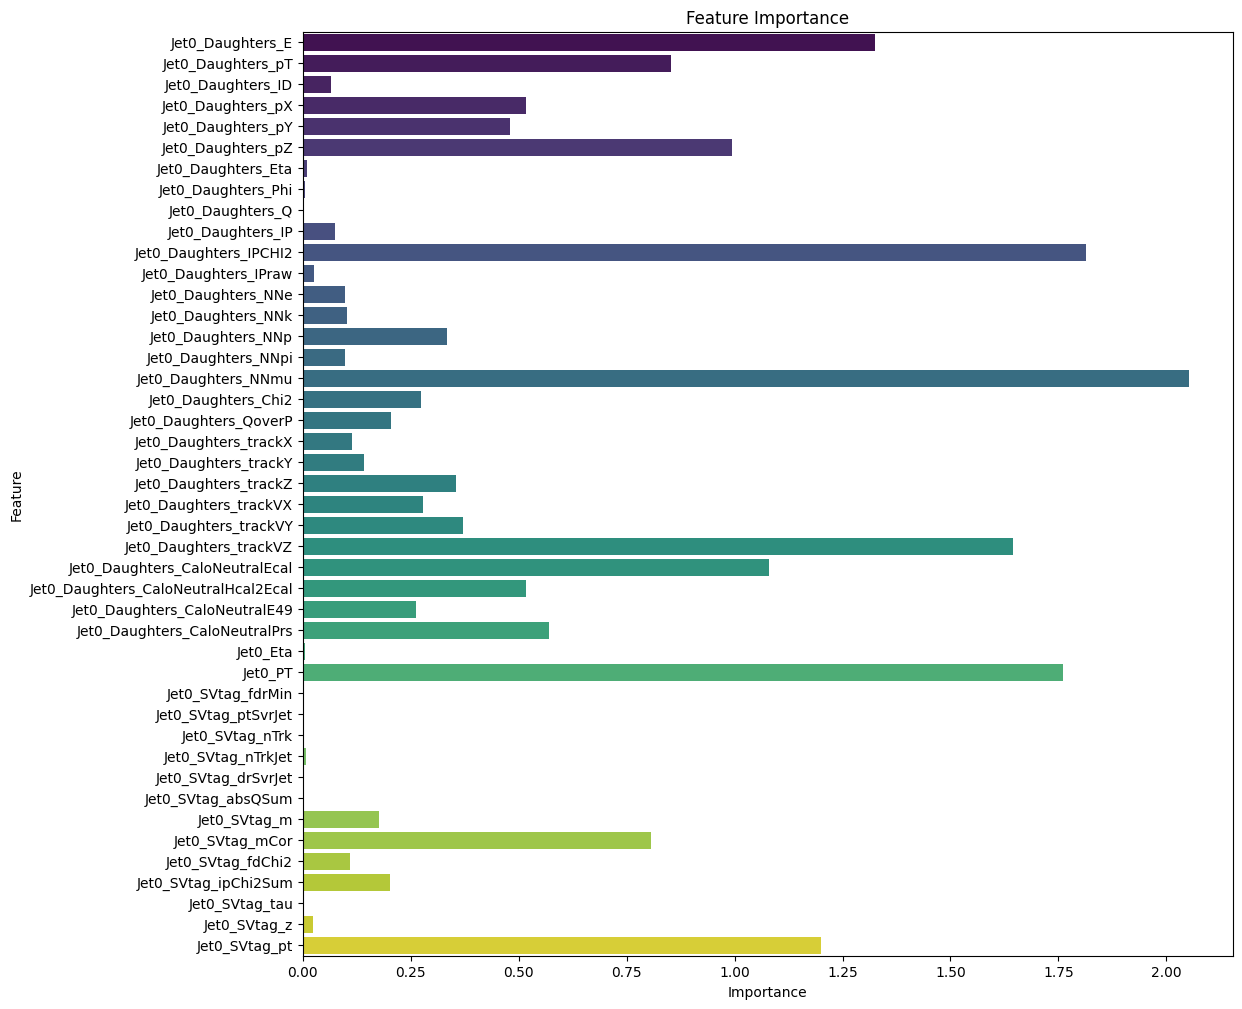

In [82]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [59]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 1.325775
Jet0_Daughters_pT & 0.853019
Jet0_Daughters_pX & 0.517047
Jet0_Daughters_pY & 0.478604
Jet0_Daughters_pZ & 0.993635
Jet0_Daughters_IPCHI2 & 1.813385
Jet0_Daughters_NNp & 0.334530
Jet0_Daughters_NNmu & 2.051632
Jet0_Daughters_Chi2 & 0.273826
Jet0_Daughters_trackZ & 0.354708
Jet0_Daughters_trackVX & 0.277653
Jet0_Daughters_trackVY & 0.371592
Jet0_Daughters_trackVZ & 1.645503
Jet0_Daughters_CaloNeutralEcal & 1.079570
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.517796
Jet0_Daughters_CaloNeutralE49 & 0.261400
Jet0_Daughters_CaloNeutralPrs & 0.570024
Jet0_PT & 1.759649
Jet0_SVtag_mCor & 0.806371
Jet0_SVtag_pt & 1.199997


# Model Probability Output

This function  inputs a random jet sample from the full dataframe before truth matching or cuts are applied and uses the trained model to output predictions of if the jet is a b-jet or not.

In [161]:
df = full_df

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Process feature columns
    for col in feature_cols:
        if col in sample_jet.columns:
            sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * int(row['Jet0_nDaughters']) if isinstance(row[col], (float, int)) else row[col], axis=1)
            sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    jet_input = data_objects

    for data in jet_input:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > 0.43696803).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b-jet')
    if prediction.item() == 0:  
        print(f'Prediction: not a b-jet')
    return probability.item()

i = 0

for i in range(100):
    bprob = make_predictions()
    qprob = make_predictions()

Probability: 0.036828164011240005
Prediction: not a b-jet
Probability: 0.19284293055534363
Prediction: not a b-jet
Probability: 0.9967026114463806
Prediction: b-jet
Probability: 0.36902517080307007
Prediction: not a b-jet
Probability: 0.3334539532661438
Prediction: not a b-jet
Probability: 0.05368337035179138
Prediction: not a b-jet
Probability: 0.12454136461019516
Prediction: not a b-jet
Probability: 0.12449076771736145
Prediction: not a b-jet
Probability: 0.49378469586372375
Prediction: b-jet
Probability: 0.09538225084543228
Prediction: not a b-jet
Probability: 0.09681998193264008
Prediction: not a b-jet
Probability: 0.3326619267463684
Prediction: not a b-jet
Probability: 0.22076518833637238
Prediction: not a b-jet
Probability: 0.4870210289955139
Prediction: b-jet
Probability: 0.32483935356140137
Prediction: not a b-jet
Probability: 0.23471838235855103
Prediction: not a b-jet
Probability: 0.2897269129753113
Prediction: not a b-jet
Probability: 0.3326965868473053
Prediction: not a b-j

For b-jet and non b-jet samples, plot distribution of fraction of jets vs probability of b-jet.

In [60]:
# Separate b and q data from testing dataset (preprocessed)
b = validation_df[validation_df.IsB == 1].head(3000)
q = validation_df[validation_df.IsB == 0].head(3000)

b_data = create_graphs(b, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
q_prob = []

model.eval()
with torch.no_grad():
    for data in b_data:
        out = model(data.x, data.edge_index, data.batch)
        bprob = torch.sigmoid(out)
        b_prob.append(bprob.numpy().flatten())
    for data in q_data:
        out = model(data.x, data.edge_index, data.batch)
        qprob = torch.sigmoid(out)
        q_prob.append(qprob.numpy().flatten())

b_prob = np.concatenate(b_prob)
q_prob = np.concatenate(q_prob)

In [75]:
# Find the cutoff for desired efficiency (sum under Pb)
b_bin_area = np.cumsum(np.diff(b_bins) * b_values)
sum(b_bin_area[:64])/sum(b_bin_area)

0.40272582755585945

In [76]:
eighty_eff = b_bins[47]
print(eighty_eff)
seventy_eff = b_bins[56]
print(seventy_eff)
sixty_eff = b_bins[64]
print(sixty_eff)

0.4764377772808075
0.5653440356254578
0.6443718671798706


/var/folders/w5/gw0llq6120v4569jh69f877m0000gq/T/ipykernel_59890/263920917.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e4)


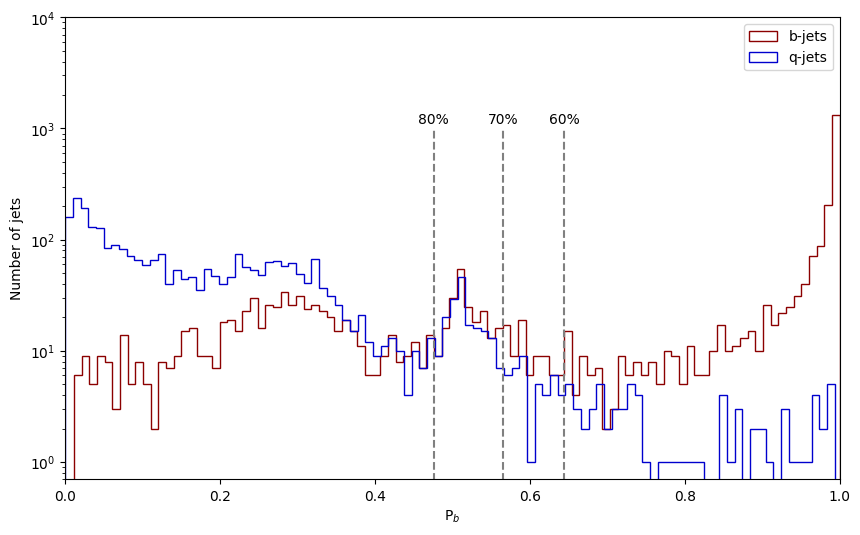

In [78]:
plt.figure(figsize=(10, 6))
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkred', histtype='step')
q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')
plt.vlines(x=eighty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(eighty_eff, 1200, '80%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=seventy_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(seventy_eff, 1200, '70%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=sixty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(sixty_eff, 1200, '60%', horizontalalignment='center', verticalalignment='center')

plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0,1e4)
plt.ylabel('Number of jets')
plt.xlabel('P$_b$')
plt.legend(loc='best')
#plt.title('Probability Distribution')
plt.show()